In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image  # You may need to install the Pillow library: !pip install Pillow

# Custom dataset class for loading and preprocessing image data
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder # Path to root directory containing data
        self.transform = transform # Function to apply to images

        # Get list of class names by listing subdirectories in root folder
        self.classes = sorted(os.listdir(root_folder))

        # Create mapping from class name to class index
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Generate list of (file_path, target) tuples for each image
        self.file_list = self.make_dataset()

    # Generate list of (file_path, target) tuples for each image
    def make_dataset(self):
        file_list = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_folder, class_name)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, file_name)
                    if os.path.isfile(file_path):
                        # Append file path and corresponding class index
                        file_list.append((file_path, self.class_to_idx[class_name]))
        return file_list # List of file paths and corresponding class indices

    # Return total number of samples isn dataset
    def __len__(self):
        return len(self.file_list)

    # Get specific sample from dataset
    def __getitem__(self, idx):
        file_path, target = self.file_list[idx]
        # Open image and convert it to RGB mode (adjust mode if needed)
        image = Image.open(file_path).convert('RGB') 

        # Apply specified image transformation (if provided)
        if self.transform:
            image = self.transform(image)

        return image, target # Tuple containing image and its target label

In [2]:
# Set path to train and test folders
train_folder_path = "hebrew-data/TRAIN"
test_folder_path = "hebrew-data/TEST"

# Define transformations for data 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(3),
    transforms.ColorJitter(brightness=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Create training and test datasets 
train_dataset = CustomDataset(train_folder_path, transform=transform)
test_dataset = CustomDataset(test_folder_path, transform=transform)

batch_size = 16

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Convert training data set into iterable
dataiter = iter(train_dataset)

# Get next batch of data from iterable
images, labels = next(dataiter)

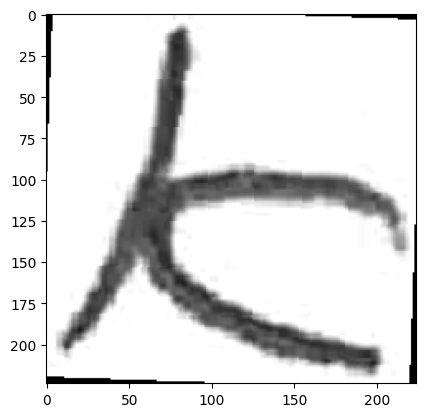

In [5]:
import matplotlib.pyplot as plt

# Display first image from batch
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Convolutional neural network (CNN) model for identifying Hebrew characters
class HandwritingCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandwritingCNN, self).__init__()

        # Define CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # New layers
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )
        
        # Calculate the size of linear layer input dynamically based on input size
        cnn_output_size = self.calculate_cnn_output_size((3, 224, 224))  # Adjust input size as needed
        self.linear_layers = nn.Sequential(nn.Linear(cnn_output_size, num_classes))

    # Calculate output size of CNN layers based on given input size
    def calculate_cnn_output_size(self, input_size):
        # Use a dummy tensor to calculate the output size of the CNN layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            cnn_output = self.cnn_layers(dummy_input)
        return cnn_output.view(1, -1).size(1) # Size of output after CNN layers

    # Forward pass of model
    def forward(self, X):
        output = self.cnn_layers(X)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output # Output of model



In [7]:
# Set number of classes based on dataset
num_classes = len(train_dataset.classes)

# Instantiate model with correct number of classes
model = HandwritingCNN(num_classes)

In [8]:
# Assuming a defined train_dataset, test_dataset, and necessary transforms
batch_size = 16

# Create training and data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch.optim as optim

# Define loss criterion and optimizer for model training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Determing computing device (GPU if available, CPU if not)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to selected device
model.to(device)
epochs = 5

# Loop over specified number of epochs
for epoch in range(epochs):
    total_loss = 0.
    model.train() # Set model in training mode

    # Iterate through training data batches
    for images, labels in train_loader:
        optimizer.zero_grad() # Clear gradients
        images, labels = images.to(device), labels.to(device)  # Move data to device
        output = model(images) # Forward pass
        loss = criterion(output, labels) # Calculate loss
        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch}, Loss: {average_loss}')


Epoch 0, Loss: 2.6881690111852463
Epoch 1, Loss: 1.1526113908377387
Epoch 2, Loss: 0.8931752743139383
Epoch 3, Loss: 0.7561742725271371
Epoch 4, Loss: 0.6881204817684428


In [11]:
import torch

total = 0
correct = 0

model.eval()  # Set model to evaluation mode

# Perform inference on test dataset and calculate accuracy
with torch.no_grad():
    for images, labels in test_loader:  # Assuming a test DataLoader
        for i in range(len(images)):
            # Reshape image to match model's input dimensions (adjust if needed)
            image = images[i].view(1, 3, 224, 224) 
            logps = model(image) # Forward pass to get logits
            _, predicted = torch.max(logps, 1) # Get predicted class
            test_y = labels[i] # True label
            total += 1
            correct += (predicted == test_y).sum().item()

# Calculate and print accuracy
accuracy = correct / total
print('Accuracy:', accuracy)

Accuracy: 0.5714285714285714
